# USAD
## Importing packages

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

In [2]:
!ls data

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


## Reading data

In [38]:
df = pd.read_csv('../datasets/swat/Physical/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')

### Processing data

In [39]:
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()

In [40]:
df.shape

(99000, 51)

In [41]:
window_size = 12
input_size = window_size * 51
latent_space = 10 * window_size
epochs = 20

In [42]:
mm = StandardScaler()

In [43]:
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [45]:
#device = torch.device('cpu')

In [46]:
class SWat_dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, target: pd.DataFrame,  window_size):
        self.data = dataframe
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.window_size]
        features = torch.tensor(window.iloc[:,:].values).float().to(device)
        return features

In [47]:
train_dataset = SWat_dataset(train_set, train_set, window_size)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Setting up the model structure

In [48]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [49]:
shared_encoder = Encoder(input_size, latent_space)
AE1 = AutoEncoder(input_size, latent_space, shared_encoder)
AE2 = AutoEncoder(input_size, latent_space, shared_encoder)

In [50]:
shared_encoder.to(device)
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=612, out_features=306, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=306, out_features=153, bias=True)
    (fc3): Linear(in_features=153, out_features=120, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=120, out_features=153, bias=True)
  (fc2): Linear(in_features=153, out_features=306, bias=True)
  (fc3): Linear(in_features=306, out_features=612, bias=True)
)

In [51]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

## Training the model

### Training

In [52]:
AE1_val_history = []
AE2_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        features = features.view(features.shape[0], -1)
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            features = features.view(features.shape[0], -1)
        
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.2630, AE2: 0.2606
Train loss: AE1 0.6110, AE2 0.5915
Epoch: 1 ---> Val loss: AE1 0.2305, AE2: -0.0274
Train loss: AE1 0.3413, AE2 -0.0283
Epoch: 2 ---> Val loss: AE1 0.2857, AE2: -0.1228
Train loss: AE1 0.6188, AE2 -0.2720
Epoch: 3 ---> Val loss: AE1 0.3147, AE2: -0.1909
Train loss: AE1 0.6370, AE2 -0.3954
Epoch: 4 ---> Val loss: AE1 0.4247, AE2: -0.3062
Train loss: AE1 0.7204, AE2 -0.5272
Epoch: 5 ---> Val loss: AE1 0.4217, AE2: -0.3537
Train loss: AE1 0.8029, AE2 -0.6919
Epoch: 6 ---> Val loss: AE1 0.4313, AE2: -0.3794
Train loss: AE1 0.8030, AE2 -0.7301
Epoch: 7 ---> Val loss: AE1 0.4269, AE2: -0.3849
Train loss: AE1 0.8130, AE2 -0.7545
Epoch: 8 ---> Val loss: AE1 0.4295, AE2: -0.3932
Train loss: AE1 0.8212, AE2 -0.7699
Epoch: 9 ---> Val loss: AE1 0.4273, AE2: -0.3964
Train loss: AE1 0.8292, AE2 -0.7874
Epoch: 10 ---> Val loss: AE1 0.4312, AE2: -0.4038
Train loss: AE1 0.8214, AE2 -0.7872
Epoch: 11 ---> Val loss: AE1 0.4265, AE2: -0.4023
Train loss: AE1 

In [53]:
def plot_history(losses1, losses2):
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.savefig('Training_history.png')
    plt.show()

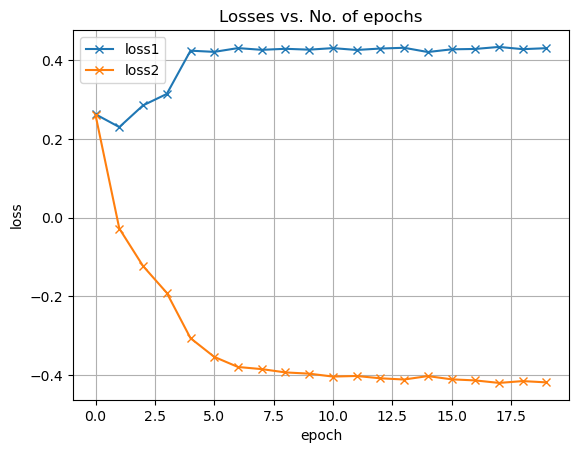

In [54]:
plot_history(AE1_val_history, AE2_val_history)

In [ ]:
torch.save(AE1.state_dict(), 'my_USAD_without_downsampling_AE1_hidden_10_random.pth')
torch.save(AE2.state_dict(), 'my_USAD_without_downsampling_AE2_hidden_10_random.pth')

In [37]:
AE1.load_state_dict(torch.load('my_USAD_without_downsampling_AE1_100_hidden.pth'))
AE2.load_state_dict(torch.load('my_USAD_without_downsampling_AE2_100_hidden.pth'))

<All keys matched successfully>

## Testing

In [55]:
df2 = pd.read_csv('../datasets/swat/Physical/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns

In [56]:
test_normalized = pd.DataFrame(mm.transform(df2))

In [57]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [58]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.view(batch.shape[0], -1)
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [59]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [60]:
np.sum(labels)

54621

In [61]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [62]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [63]:
np.sum(y_test)

55006.0

In [64]:
results=testing(test_loader)

In [65]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [66]:
y_pred.shape

(449907,)

In [67]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

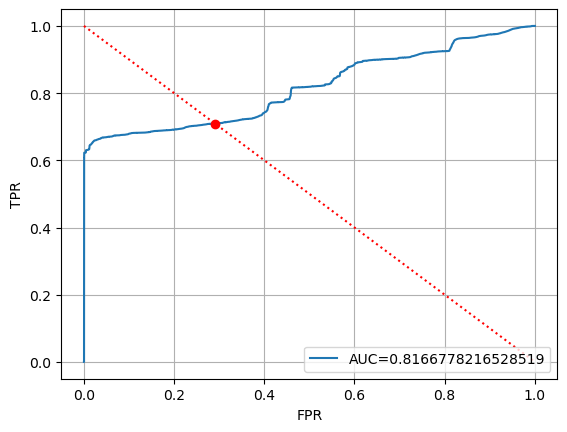

In [68]:
threshold = ROC(y_test,y_pred)

In [69]:
threshold

array([6.2146053], dtype=float32)

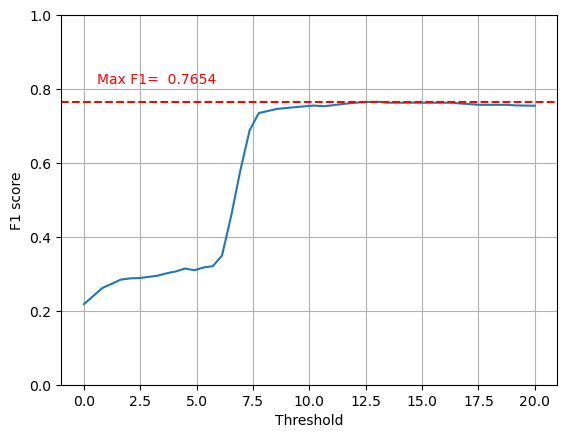

In [73]:
x_vals = 0. + np.linspace(0, 20, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('my_plot.png')

plt.show()

best: 13.061224489795919 F1: 0.7654229939771826


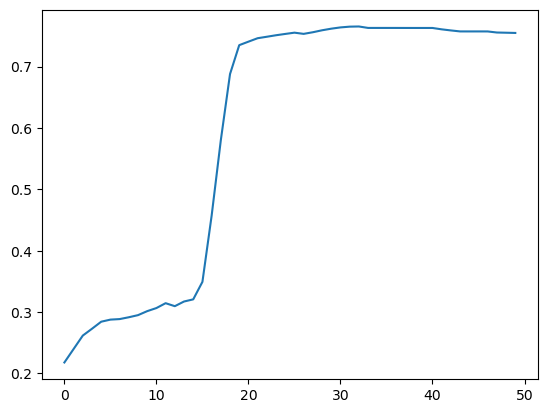

In [70]:
ff = 0
f_history = []
initial_y = 0.
best = -1
for inc in np.linspace(0, 20, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [76]:
y_pred_int = [1 if (yy > 13.) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.9928975213799102
Recall: 0.622659346253136
F1 Score: 0.7653545770438319
TP: 34250
TN: 394656
FP: 245
FN: 20756


# Try adjust point

In [77]:
best

13.061224489795919